# Glycosyltransferases

## Imports

In [1]:
import subprocess
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11.0, 7.0)

In [2]:
DATA = Path("../data")
RESULTS = Path("../results")

## Read and filter data 

In [3]:
gt = pd.read_table(DATA / "glycosyltransferases.txt") #, compression="gzip")

Apply filter.

In [4]:
gt["biotype"].value_counts()

protein_coding    244
Name: biotype, dtype: int64

### Check and add CAZy families 

Read gene names and families from CAZy data (checked 2017-10-17). 

In [5]:
cazy_genes = pd.read_table(DATA / "cazy_proper_gene_names.txt")

# dict with gene_name: cazy_families mapping
cazy_families = {}
for indx, rec in cazy_genes.iterrows():
    if rec["Mapped gene name"]:
        if not rec["Mapped gene name"] in cazy_families:
            cazy_families[rec["Mapped gene name"]] = []
        cazy_families[rec["Mapped gene name"]].append(rec["Family"])

In [6]:
def add_cazy(gt_df, cazy_dict):
    result = []
    for idx, row in gt_df.iterrows():
        gene = row["geneSymbol"]
        new_fams = cazy_dict.get(gene)

        cazy = set()
        
        if not isinstance(row["cazy"], float):
            for old in row["cazy"].split(","):
                cazy.add(old)
        
        if new_fams:
            for new in new_fams:
                cazy.add(new)

        if cazy:
            result.append(",".join(sorted(cazy)))
        else:
            result.append(float("nan"))

    return result

In [7]:
gt["new_cazy"] = add_cazy(gt, cazy_families)

After addition of families from CAZy, the following entries were updated.

In [8]:
upd = gt[gt["new_cazy"].notnull()]
upd = upd[upd["cazy"] != upd["new_cazy"]]

upd[["geneSymbol", "cazy", "new_cazy"]]

geneSymbol  cazy   new_cazy
1     A3GALT2   NaN        GT6
13      ALG10  GT59  GT33,GT59
67      EXTL2  GT64  GT47,GT64

Drop old table and replace with the new one.

In [9]:
gt["cazy"] = gt["new_cazy"]
del gt["new_cazy"]

## Analysis

In [10]:
print("There are", len(gt), "glycosyltransferases.")

There are 244 glycosyltransferases.


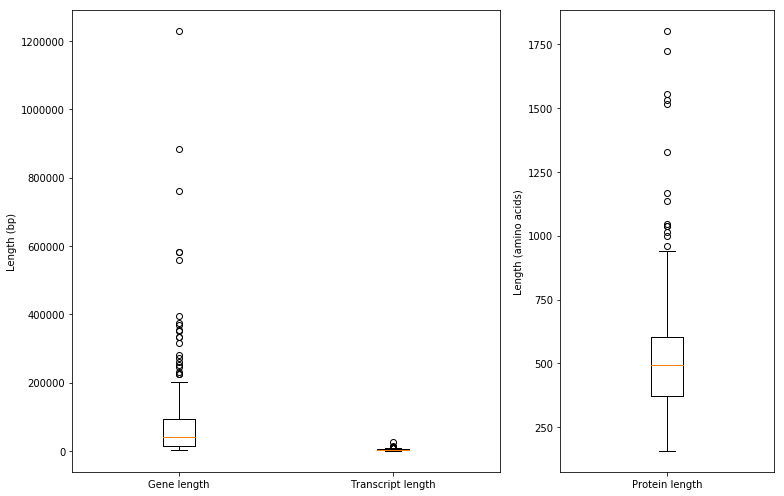

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, gridspec_kw={"width_ratios": [2,1]})

axes[0].boxplot([gt.geneLength, gt.transcriptLength])
axes[1].boxplot(gt.proteinLength)
axes[0].set(ylabel="Length (bp)", xticks=[1, 2], xticklabels=["Gene length", "Transcript length"])
axes[1].set(ylabel="Length (amino acids)", xticks=[1], xticklabels=["Protein length"])
fig.tight_layout()

In [12]:
fig.savefig(str(RESULTS / "gt_gene_transcript_protein_length.png"))

The longest genes.

In [13]:
cols = ["geneSymbol", "geneLength", "transcriptLength", "proteinLength"]
gt.nlargest(5, "geneLength")[cols]

geneSymbol  geneLength  transcriptLength  proteinLength
116    GALNTL6     1229306              3922            601
163     MGAT4C      883239             25116            478
158     LARGE1      760616              4409            756
114    GALNT13      581937              2591            561
121    GALNT17      581432              3884            598

The shortest genes.

In [14]:
gt.nsmallest(5, "geneLength")[cols]

geneSymbol  geneLength  transcriptLength  proteinLength
25      B4GAT1        2321              2072            415
18        APRT        2606               947            180
168      MGAT2        2687              2687            447
50     B3GALT6        2777              2777            329
76        FUT7        2837              2584            342

Median (min-max) gene lengths.

In [15]:
gt["geneLength"].describe().astype(int)

count        244
mean       84275
std       138430
min         2321
25%        15098
50%        40799
75%        92623
max      1229306
Name: geneLength, dtype: int64

Total length of all genes.

In [16]:
print("Total length {:,} bp.".format(gt["geneLength"].sum()))

Total length 20,563,185 bp.


The longest proteins.

In [17]:
gt.nlargest(5, "proteinLength")[cols]

geneSymbol  geneLength  transcriptLength  proteinLength
189     PARP14       50223              7915           1801
191      PARP4       91885              5474           1724
236      UGGT1      104478             10650           1555
107        AGL       73940              7446           1532
238      UGGT2      251903              4832           1516

The shortest proteins.

In [18]:
gt.nsmallest(5, "proteinLength")[cols]

geneSymbol  geneLength  transcriptLength  proteinLength
196       PIGP       14001              3437            158
18        APRT        2606               947            180
200       PIGH       18333              1420            188
4        ALG1L        7765               701            207
5       ALG1L2       31397               969            215

In [19]:
gt["proteinLength"].describe()

count     244.000000
mean      534.524590
std       249.162505
min       158.000000
25%       373.500000
50%       492.000000
75%       604.000000
max      1801.000000
Name: proteinLength, dtype: float64

### CAZy

In [20]:
def cazy_families(gt):
    fam = []
    for row in gt.itertuples(index=False):
        if isinstance(row.cazy, float):
            continue
        fields = row.cazy.split(",")
        for field in fields:
            if field.startswith("GT"):
                fam.append(field)
    return pd.Series(fam)

In [21]:
cazy = cazy_families(gt)

In [22]:
print("Glycosyltransferases are distributed over", len(cazy.unique()), "families")

Glycosyltransferases are distributed over 44 families


In [23]:
print(gt.cazy.notnull().sum(), "entries have CAZy annotations.")
print(gt.cazy.isnull().sum(), "entries do not have CAZy annotations.")

199 entries have CAZy annotations.
45 entries do not have CAZy annotations.


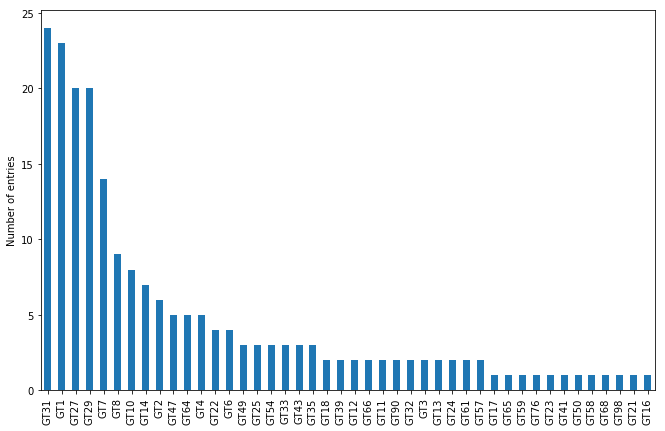

In [24]:
fig, ax = plt.subplots()
cazy.value_counts().plot.bar(ax=ax)
ax.set(ylabel="Number of entries")

In [25]:
fig.savefig(str(RESULTS / "gt_families.png"))

### Length UTRs

Get the totalt length of exons.

In [26]:
gt["relativeFivePrimeUtrLength"] = gt["fivePrimeUtrLength"] / gt["transcriptLength"]
gt["relativeThreePrimeUtrLength"] = gt["threePrimeUtrLength"] / gt["transcriptLength"]

gt["combinedUtrLength"] = gt["fivePrimeUtrLength"] + gt["threePrimeUtrLength"]
gt["relativeCombinedUtrLength"] = gt["combinedUtrLength"] / gt["transcriptLength"]

In [27]:
fields = ["fivePrimeUtrLength", "relativeFivePrimeUtrLength", "threePrimeUtrLength", "relativeThreePrimeUtrLength", 
          "combinedUtrLength", "relativeCombinedUtrLength"]
gt[fields].describe()

fivePrimeUtrLength  relativeFivePrimeUtrLength  threePrimeUtrLength  \
count          244.000000                  244.000000           244.000000   
mean           321.987705                    0.090462          1928.905738   
std            431.549362                    0.098812          2470.899389   
min              0.000000                    0.000000             0.000000   
25%             81.750000                    0.025480           472.750000   
50%            204.500000                    0.055322          1129.500000   
75%            398.250000                    0.138988          2447.750000   
max           4545.000000                    0.792226         23623.000000   

       relativeThreePrimeUtrLength  combinedUtrLength  \
count                   244.000000         244.000000   
mean                      0.398732        2250.893443   
std                       0.230110        2534.332564   
min                       0.000000           0.000000   
25%                       0.211543         729.500000   
50%                       0.370914        1454.000000   
75%                       0.595844        2966.500000   
max                       0.940556       23679.000000   

       relativeCombinedUtrLength  
count                 244.000000  
mean                    0.489195  
std                     0.223299  
min                     0.000000  
25%                     0.326345  
50%                     0.494779  
75%                     0.661442  
max                     0.942785

In [28]:
gt[fields].median()

fivePrimeUtrLength              204.500000
relativeFivePrimeUtrLength        0.055322
threePrimeUtrLength            1129.500000
relativeThreePrimeUtrLength       0.370914
combinedUtrLength              1454.000000
relativeCombinedUtrLength         0.494779
dtype: float64

The 3'UTR is typically longer with a median proportion of 0.036 of the transcript.

The GTs with the longest relative 5'UTR.

In [29]:
cols = ["geneSymbol", "transcriptId", "geneLength", "transcriptLength", "proteinLength",
        "relativeFivePrimeUtrLength", "fivePrimeUtrLength", "relativeThreePrimeUtrLength", "threePrimeUtrLength",
        "combinedUtrLength", "relativeCombinedUtrLength"]
gt.nlargest(5, "relativeFivePrimeUtrLength")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
22      B3GAT1  ENST00000524765       33415              5737            334   
203       PIGC  ENST00000367728       73898              2630            297   
76        FUT7  ENST00000314412        2837              2584            342   
80        FUT6  ENST00000318336        9122              3137            359   
62       CHPF2  ENST00000035307        6339              3978            772   

     relativeFivePrimeUtrLength  fivePrimeUtrLength  \
22                     0.792226                4545   
203                    0.556654                1464   
76                     0.394350                1019   
80                     0.380937                1195   
62                     0.380342                1513   

     relativeThreePrimeUtrLength  threePrimeUtrLength  combinedUtrLength  \
22                      0.032595                  187               4732   
203                     0.103422                  272               1736   
76                      0.207430                  536               1555   
80                      0.274785                  862               2057   
62                      0.036702                  146               1659   

     relativeCombinedUtrLength  
22                    0.824821  
203                   0.660076  
76                    0.601780  
80                    0.655722  
62                    0.417044

The GTs with the shortest relative 5'UTR.

In [30]:
gt.nsmallest(5, "relativeFivePrimeUtrLength")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
1     A3GALT2  ENST00000442999       14333              1023            340   
4       ALG1L  ENST00000611639        7765               701            207   
36    B3GALT5  ENST00000398714      116696              2341            314   
42   B4GALNT4  ENST00000329962       12321              3444           1039   
81     GALNT9  ENST00000328957      132978              2410            603   

    relativeFivePrimeUtrLength  fivePrimeUtrLength  \
1                          0.0                   0   
4                          0.0                   0   
36                         0.0                   0   
42                         0.0                   0   
81                         0.0                   0   

    relativeThreePrimeUtrLength  threePrimeUtrLength  combinedUtrLength  \
1                      0.000000                    0                  0   
4                      0.109843                   77                 77   
36                     0.596326                 1396               1396   
42                     0.094077                  324                324   
81                     0.248133                  598                598   

    relativeCombinedUtrLength  
1                    0.000000  
4                    0.109843  
36                   0.596326  
42                   0.094077  
81                   0.248133

How many have no 5'UTR.

In [31]:
(gt["fivePrimeUtrLength"] == 0).sum()

10

The relatively longest and shortest 3'UTRs.

In [32]:
gt.nlargest(5, "relativeThreePrimeUtrLength")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
163     MGAT4C  ENST00000611864      883239             25116            478   
14       ALG14  ENST00000370205       98539              9367            216   
86        FUT9  ENST00000302103      199629             12783            359   
141    ST8SIA5  ENST00000538168       91437             13761            412   
120      GTDC1  ENST00000392869      394501             10514            458   

     relativeFivePrimeUtrLength  fivePrimeUtrLength  \
163                    0.002230                  56   
14                     0.005018                  47   
86                     0.025503                 326   
141                    0.021873                 301   
120                    0.014552                 153   

     relativeThreePrimeUtrLength  threePrimeUtrLength  combinedUtrLength  \
163                     0.940556                23623              23679   
14                      0.925483                 8669               8716   
86                      0.890010                11377              11703   
141                     0.888090                12221              12522   
120                     0.854480                 8984               9137   

     relativeCombinedUtrLength  
163                   0.942785  
14                    0.930501  
86                    0.915513  
141                   0.909963  
120                   0.869032

In [33]:
gt.nsmallest(5, "relativeThreePrimeUtrLength")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
1      A3GALT2  ENST00000442999       14333              1023            340   
221       TYMP  ENST00000395681        4305              1604            487   
202    POMGNT1  ENST00000371992       31624              2934            748   
17        ALG8  ENST00000299626       38725              1675            526   
182     PARP15  ENST00000464300       61446              2156            678   

     relativeFivePrimeUtrLength  fivePrimeUtrLength  \
1                      0.000000                   0   
221                    0.076060                 122   
202                    0.221881                 651   
17                     0.042985                  72   
182                    0.030612                  66   

     relativeThreePrimeUtrLength  threePrimeUtrLength  combinedUtrLength  \
1                       0.000000                    0                  0   
221                     0.011222                   18                140   
202                     0.012270                   36                687   
17                      0.013134                   22                 94   
182                     0.024583                   53                119   

     relativeCombinedUtrLength  
1                     0.000000  
221                   0.087282  
202                   0.234151  
17                    0.056119  
182                   0.055195

Many GTs have very long 3'UTRs.

And now for the combined 5' and 3'UTR.

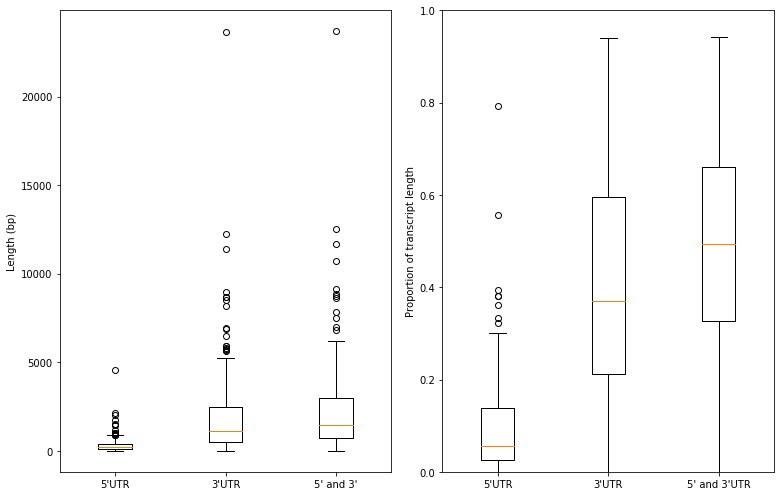

In [34]:
fig, axes = plt.subplots(1, 2)

axes[0].boxplot([gt["fivePrimeUtrLength"],
                 gt["threePrimeUtrLength"],
                 gt["combinedUtrLength"]])
axes[0].set(ylabel="Length (bp)",
            xticks=[1, 2, 3],
            xticklabels=["5'UTR", "3'UTR", "5' and 3'"])

axes[1].boxplot([gt["relativeFivePrimeUtrLength"],
                 gt["relativeThreePrimeUtrLength"],
                 gt["relativeCombinedUtrLength"]])
axes[1].set(ylabel="Proportion of transcript length",
            xticks=[1, 2, 3],
            xticklabels=["5'UTR", "3'UTR", "5' and 3'UTR"],
            ylim=[0.0, 1.0])

fig.tight_layout()
fig.savefig(str(RESULTS / "UTR_lengths.png"))

In [35]:
gt.nlargest(5, "combinedUtrLength")[cols]

geneSymbol     transcriptId  geneLength  transcriptLength  proteinLength  \
163     MGAT4C  ENST00000611864      883239             25116            478   
141    ST8SIA5  ENST00000538168       91437             13761            412   
86        FUT9  ENST00000302103      199629             12783            359   
137    ST8SIA3  ENST00000324000       20919             11833            380   
120      GTDC1  ENST00000392869      394501             10514            458   

     relativeFivePrimeUtrLength  fivePrimeUtrLength  \
163                    0.002230                  56   
141                    0.021873                 301   
86                     0.025503                 326   
137                    0.171892                2034   
120                    0.014552                 153   

     relativeThreePrimeUtrLength  threePrimeUtrLength  combinedUtrLength  \
163                     0.940556                23623              23679   
141                     0.888090                12221              12522   
86                      0.890010                11377              11703   
137                     0.731514                 8656              10690   
120                     0.854480                 8984               9137   

     relativeCombinedUtrLength  
163                   0.942785  
141                   0.909963  
86                    0.915513  
137                   0.903406  
120                   0.869032

## Output final table

In [36]:
gt.to_csv(RESULTS / "glycosyltransferases.txt", sep="\t", index=False)